In [1]:
import sys
sys.path.append('..')
import os
import numpy as np
import torch
import torch.nn.functional as F
from base import BaseModel, sample_random, sample_uniform, sample_boundary2D_separate
from base import Random_Basis_Function,Random_Basis_Function_L
from vortex.visualize import draw_vector_field2D, draw_sc_field2D, draw_curl, draw_magnitude, save_numpy_img, save_figure, draw_vector_field2D_ut
from base import gradient, divergence, laplace, jacobian
# from torchsparsegradutils import sparse_triangular_solve, sparse_generic_solve
# from torchsparsegradutils.utils import linear_cg, minres, rand_sparse, rand_sparse_tri
from vortex.sparse_solver import sparse_solve
from scipy import sparse
from vortex.model import Vortex_L

from matplotlib import pyplot as plt

PyTorch version: 2.0.1+cu118
Default GPU is NVIDIA GeForce RTX 3090
Running on cuda
CuPy version: 12.1.0
Running on  <CUDA Device 0>


In [2]:
import os
import argparse
from vortex import Vortex_L


# create experiment config containing all hyperparameters
cfg = argparse.ArgumentParser(add_help=False)

cfg.rho = 1
cfg.internal_v = 8
cfg.variable_list = [2,3]
cfg.time_num = 10
cfg.colloation_pts_num  = 3000
cfg.boundary_num = 1000
cfg.output_path = './results' 
cfg.gravity = 0
cfg.num_per_point_feature = 4
cfg.time_length = 0.2
cfg.num_spatial_basis = 400
cfg.variable_num = 3
cfg.dim = 2
cfg.device = 'cuda'
#cfg.band_width = 0.5
cfg.log_dir = './log'
cfg.n_timesteps = 100000
cfg.neighbor_K  = 4
cfg.vis_resolution = 100
cfg.seed = 67343
cfg.dt = 0.01
model = Vortex_L(cfg)

In [3]:
# print(model.spatial_A.shape,model.basis_point.shape)

# fig, ax = plt.subplots(figsize=(5, 5))
# #ax.quiver(x, y, u, v, scale=u.shape[0], scale_units='width')
# ax.scatter(model.basis_point[:,0].detach().cpu().numpy(), model.basis_point[:,1].detach().cpu().numpy())
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
# fig.tight_layout()

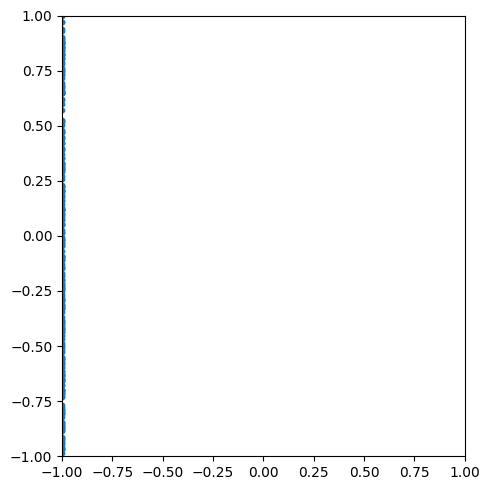

In [4]:
# print(model.time_A.shape)
# print(model.bias.shape)

fig, ax = plt.subplots(figsize=(5, 5))
#ax.quiver(x, y, u, v, scale=u.shape[0], scale_units='width')
ax.scatter(model.total_samples[0,model.u_left,0].detach().cpu().numpy(), model.total_samples[0,model.u_left,1].detach().cpu().numpy(),s=10)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
fig.tight_layout()

tensor([[-0.3292, -0.4523],
        [-0.3292,  0.5477],
        [ 0.6708, -0.4523],
        [ 0.6708,  0.5477]], device='cuda:0', grad_fn=<SelectBackward0>)


/tmp/ipykernel_276946/1668308001.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(model.total_samples[43,0].detach().cpu().numpy(), model.total_samples[43,1].detach().cpu().numpy(),c=np.array([1,0,0]))


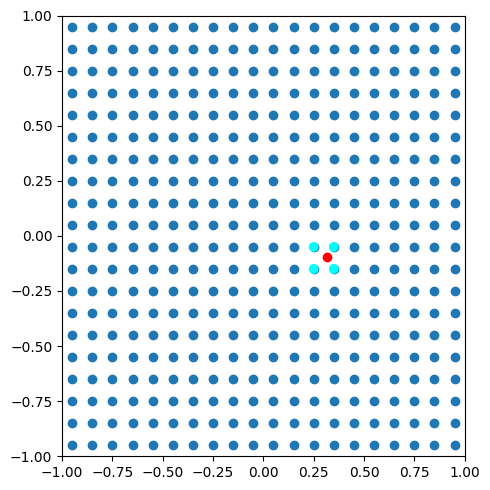

In [5]:
ts,qs,ds = model.total_samples.shape
model.total_samples = model.total_samples.reshape(ts*qs,ds)
x_,idx = model.neighbor_search_spatial(model.total_samples.reshape(ts,qs,ds))

fig, ax = plt.subplots(figsize=(5, 5))
#ax.quiver(x, y, u, v, scale=u.shape[0], scale_units='width')
# print(x_.shape)
ct = np.repeat(np.array([[0,1,1]]),x_.shape[2],axis=0)
# print(ct.shape)
#A_ = x_.reshape(-1,2)
#ct = np.repeat(np.array([[0,0,1]]),A_.shape[0],axis=0)
ax.scatter(model.total_samples[43,0].detach().cpu().numpy(), model.total_samples[43,1].detach().cpu().numpy(),c=np.array([1,0,0]))
ax.scatter(model.basis_point[0,:,0].detach().cpu().numpy(), model.basis_point[0,:,1].detach().cpu().numpy())
ax.scatter(model.basis_point[0,idx[0,43],0].detach().cpu().numpy(), model.basis_point[0,idx[0,43],1].detach().cpu().numpy(),c=ct)
print(x_[0,43])
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
fig.tight_layout()


In [6]:
total_ = model.num_time_feature*model.num_spatial_basis
h = idx.shape[2]
bz = idx.shape[1]
#print(idx.shape)
# Size is a problem here, we might abondon time
A_process = model.spatial_A.reshape(model.num_time_feature,model.num_spatial_basis,-1)
A_process = A_process.unsqueeze(1).expand(-1,bz,-1,-1)
idx_ = idx.unsqueeze(-1).expand(-1,-1,-1,A_process.shape[-1]) 
#print(A_process.shape,idx_.shape)
A_process = torch.gather(A_process,2,idx_)
A_process = A_process.reshape(model.num_time_feature,-1,h,model.variable_num,model.num_per_point_feature,model.dim)
#t_process_ = model.time_A.reshape(total_,-1)
#t_process_ = t_process_.unsqueeze(0).expand(bz,-1,-1)
#idx_ = idx.unsqueeze(-1).expand(-1,-1,t_process_.shape[-1])
#t_process_ = torch.gather(t_process_,1,idx_).reshape(-1,h,model.variable_num,model.num_per_point_feature)
bias_process = model.bias.reshape(model.num_time_feature,model.num_spatial_basis,-1)
bias_process = bias_process.unsqueeze(1).expand(-1,bz,-1,-1)
idx_ = idx.unsqueeze(-1).expand(-1,-1,-1,bias_process.shape[-1]) 
bias_process = torch.gather(bias_process,2,idx_).reshape(model.num_time_feature,-1,h,model.variable_num,model.num_per_point_feature)
#print(x_.shape)
sptail_val = torch.einsum('tqhejd,tqhd->tqhej',A_process,x_)

#time_val = torch.einsum('qhej,qh->qhej',t_process_,t_)
ot = model.non_linear(sptail_val+bias_process)
#print(sptail_val[0,model.u_left[0]])
# print(A_process[432,0],x_[432,0])
# print(idx[432])
# print(model.spatial_A.reshape(total_,-1)[248])
# print(sptail_val[432,0])
x_weight = model.PoU(x_)

x_weight = x_weight[...,0] * x_weight[...,1]
#print(x_weight)
ot = ot * x_weight[...,None,None]
delta_t = 0.01

t_,q_,h_,e_,j_ = ot.shape

ot_lap = ot.permute(0,1,2,4,3).reshape(t_,q_,h_,j_,e_)[...,1:2]
ot_lap = ot_lap.reshape(t_*q_,-1)

ot = ot.reshape(ot.shape[0]*ot.shape[1],-1)
#x_ = x_.reshape(x_.shape[0],-1)
L1,_ = jacobian(ot, model.total_samples)

lap_g,_ = jacobian(ot_lap,model.total_samples)
lap,_ = jacobian(lap_g.reshape(t_*q_,-1),model.total_samples)
lap = lap.reshape(t_,q_,h_,j_,model.dim,model.dim)
lap_g = lap_g.reshape(t_,q_,h_,j_,model.dim)
lap = torch.einsum('abcdee->abcd',lap)

ot = ot.reshape(t_*q_,h_,e_,j_)

# div_pe = ot.permute(0,1,3,2).reshape(-1,e_)
# #print(model.total_samples.shape)
# div = divergence(div_pe[...,:2], model.total_samples)
# div = div.reshape(t_,q_,h_,j_)

L1 = L1.reshape(t_,q_,h_,e_,j_,-1)



# print(L1[432,0])
L2 = None
# Lt,_ = jacobian(ot,model.t)
# Lt = Lt.reshape(q_,h_,e_,j_,-1)
ot = ot.reshape(t_,q_,h_,e_,j_ )

In [7]:
j = model.num_per_point_feature
num = 0
# h_use = idx.shape[1]
# bz_use = idx.shape[0]
# total_use = model.num_time_feature * model.num_spatial_basis
# idx_box = model.idx_box.reshape(total_use,-1)
# idx_box = idx_box.unsqueeze(0).expand(bz_use,-1,-1)
# idx_ = idx.unsqueeze(-1).expand(-1,-1,idx_box.shape[-1])
# idx_box = torch.gather(idx_box,1,idx_).reshape(-1,h_use,model.variable_num,model.num_per_point_feature)

h_use = idx.shape[2]
bz_use = idx.shape[1]
 
idx_box = model.idx_box.reshape(model.num_spatial_basis,-1)

idx_box = idx_box.unsqueeze(0).expand(bz_use,-1,-1)
print(idx[0].shape)
idx_ = idx[0].unsqueeze(-1).expand(-1,-1,idx_box.shape[-1]) 
idx_box = torch.gather(idx_box,1,idx_).reshape(-1,h_use,model.variable_num,model.num_per_point_feature)


torch.Size([4000, 4])


In [8]:
def linear_solver(LHS_tp,RHS_tp,idx_tp,time):
    LHS = []
    RHS = []
    idx = []
    num = 0
    for i,LHS_ in enumerate(LHS_tp):
        max_x = torch.abs(LHS_)
        max_x = torch.max(max_x,1).values + 1e-10
        # if max_x>0.0:
        LHS.append(LHS_/max_x[:,None])
        RHS.append(RHS_tp[i]/max_x)
        idx_tp[i][:,1] = idx_tp[i][:,1] + num
        idx.append(idx_tp[i])
        #print(LHS_.shape[0]*LHS_.shape[1],idx_tp[i].shape[0],RHS_tp[i].shape)
        num += LHS_.shape[0] 
    #LHS: q?h?ej
    q = sum([i.shape[0] for i in LHS])
    h = model.num_spatial_basis*model.variable_num*model.num_per_point_feature

    LHS = torch.cat([i.reshape(-1) for i in LHS],dim=0)
    idx = torch.cat(idx,dim=0).long()
    idx = torch.stack([idx[:,1],idx[:,0]],dim=1)

    # cuda cupy ver
    #A = torch.sparse_coo_tensor(idx.transpose(0,1),LHS,[q,h])
    #b = torch.cat(RHS,dim=0)
    LHS_s = LHS
    idx_s = idx
    # numpy ver
    LHS = LHS.double().detach().cpu().numpy()
    idx = idx.detach().cpu().numpy()
    A = sparse.coo_matrix((LHS,(idx[:,0],idx[:,1])),shape=(q,h)).tocsr()
    #print(idx[:,1])
    b = torch.cat(RHS,dim=0).double().detach().cpu().numpy()
    #print(b.shape,A.shape)


    utz = A.shape[1]
    idxu = (A.getnnz(0)>0)
    
    
    A = A[:,A.getnnz(0)>0]
    out = sparse.linalg.lsqr(A,b)
    b_ = b
    #print(out[1:5])
    num1 = LHS_tp[0].shape[0]
    num2 = LHS_tp[1].shape[0]
    #print(num1,out[0].shape)
    if len(LHS_tp)>3:
        print(np.linalg.norm(A[:num1]@out[0]-b[:num1]))

    a,b,c,d = model.u_.shape
    u = out[0]
    # print(np.sum(np.abs(u)))
    ut = np.zeros(utz)
    ut[idxu] = u
    ut = torch.from_numpy(ut).to(model.device)
    
    model.u_ = model.u_.reshape(a,-1)
    #print(ut)
    with torch.no_grad():
        model.u_[time] = ut
    #print("model time",model.u_[time])
    model.u_ = model.u_.reshape(a,b,c,d)

    out,p = model.inference_time(model.total_samples.reshape(model.num_time_feature,-1,model.dim)[:,:],time)
    velos, samples = out,model.total_samples.reshape(model.num_time_feature,-1,model.dim)[time,:]
    velos = velos.detach().cpu().numpy()
    #print(velos.shape)
    samples = samples.detach().cpu().numpy()
    velos = velos.reshape(-1,model.variable_list[0])
    p = p.detach().cpu().numpy().reshape(-1,1)
    samples = samples.reshape(-1,2)
    #print(velos.shape,samples.shape)
    #print(np.max(velos[:,:].reshape(-1,2),axis=0))
    fig = draw_vector_field2D(velos[:,:], samples[:,:])
    print(np.min(p),np.max(p))
    fig2 = draw_sc_field2D(p[:,:], samples[:,:])


# Here, we first consider 2D advection.

0.0 0.0
734.1046437819252
-2428.968 1835.9656
4304.586000392776
-7288.1484 11957.637
25864.86624006725
-66250.836 29776.16
113279.81223533816
-236683.42 170599.89
547214.0941040212
-595824.94 1920705.2
881753.0631657101
-3638096.2 2301834.5
3387552.6015248443
-9603578.0 16483101.0
1987314.9803659392
-4002859.2 3380934.0
3683862.1083837
-4797962.5 4597358.5


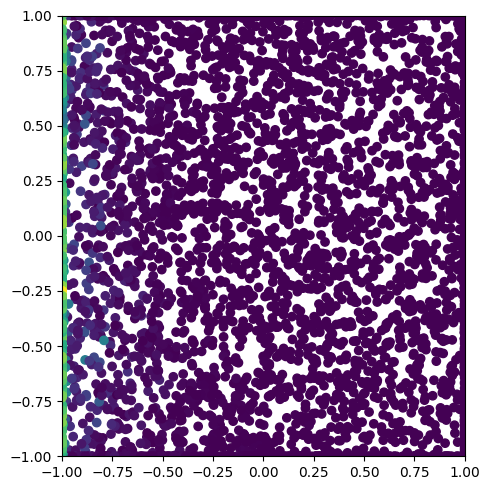

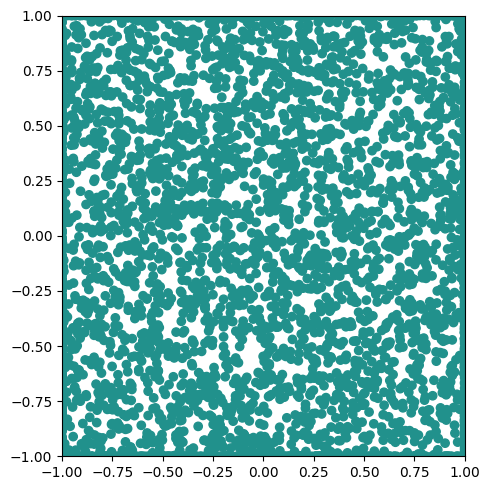

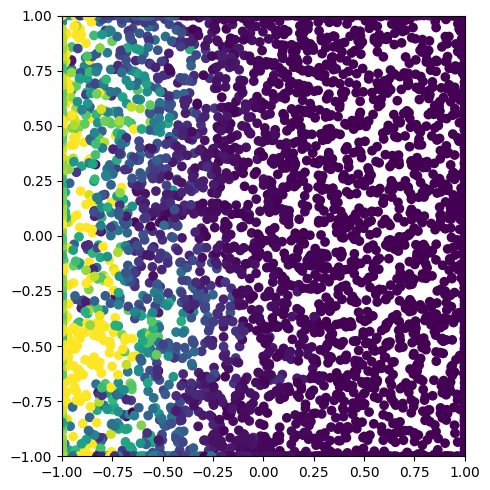

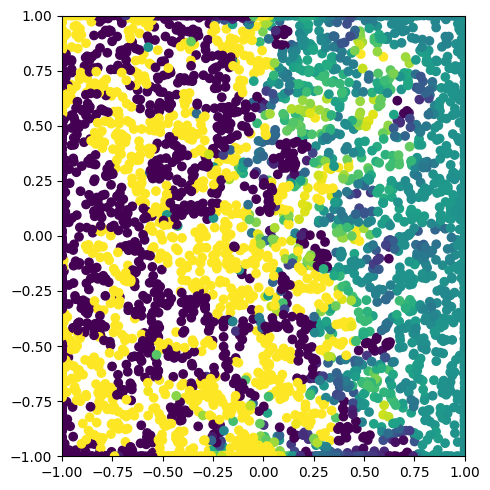

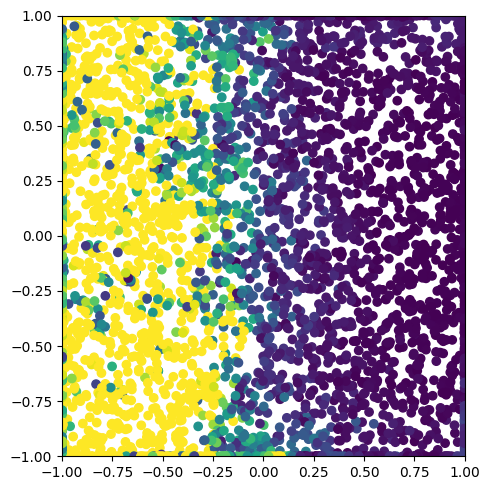

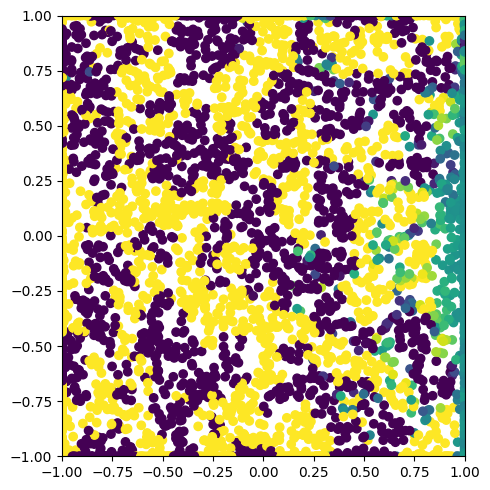

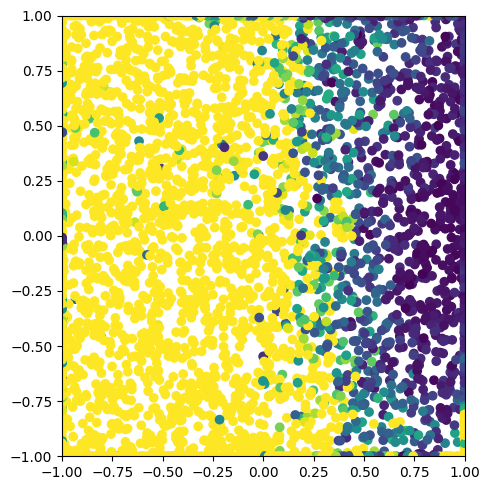

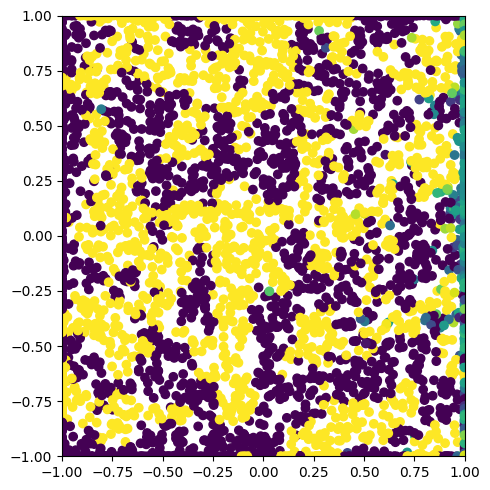

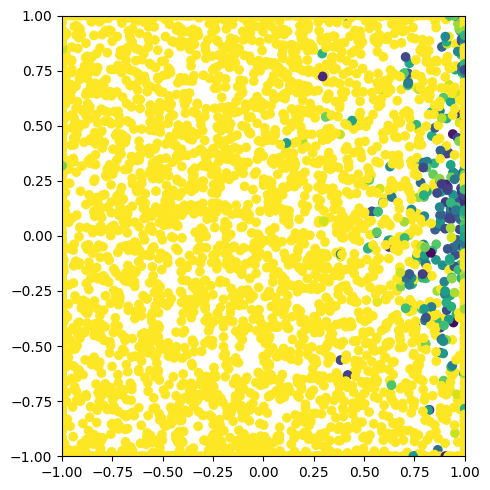

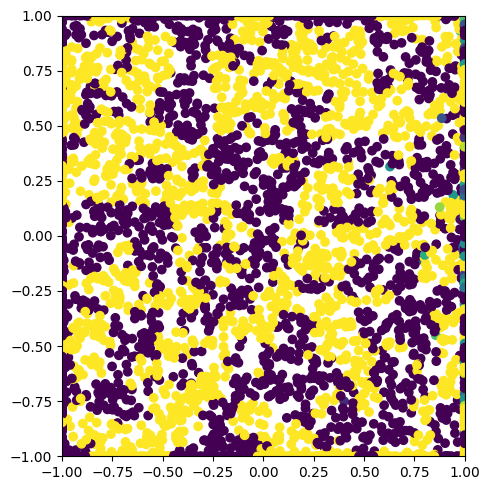

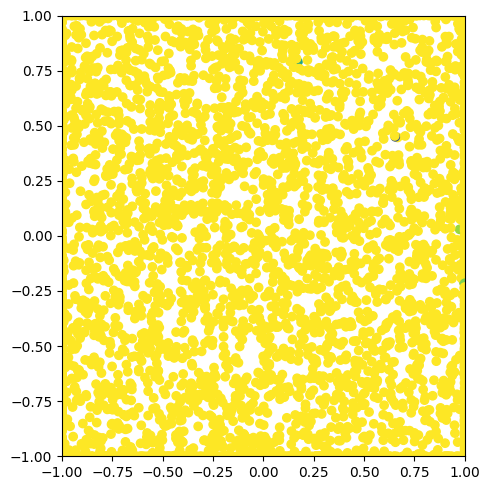

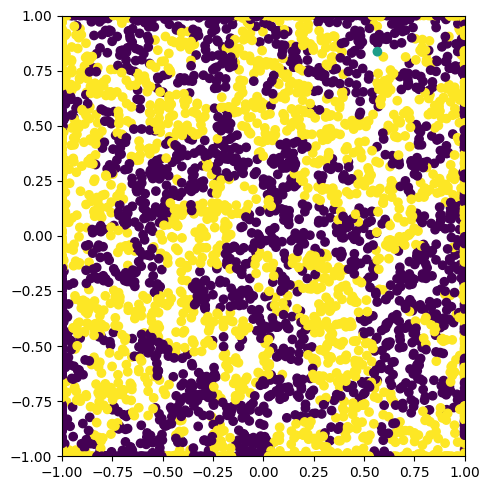

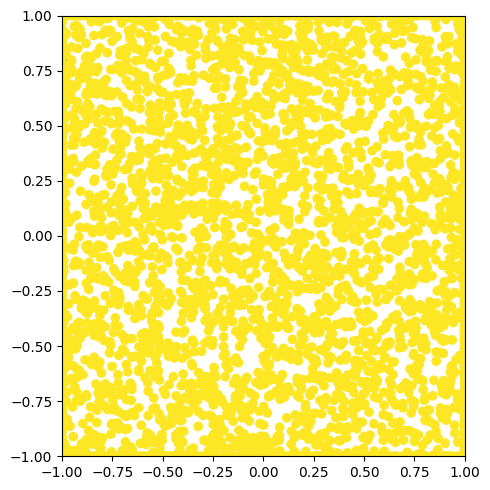

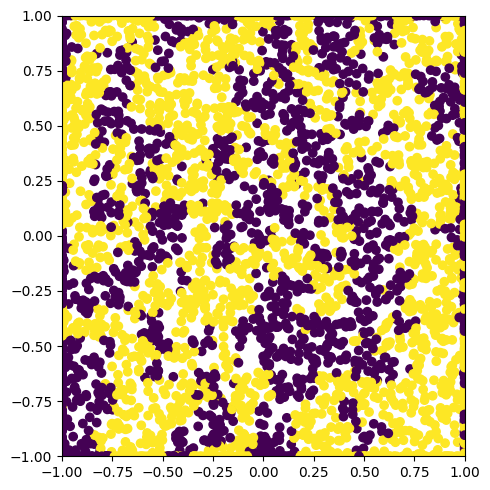

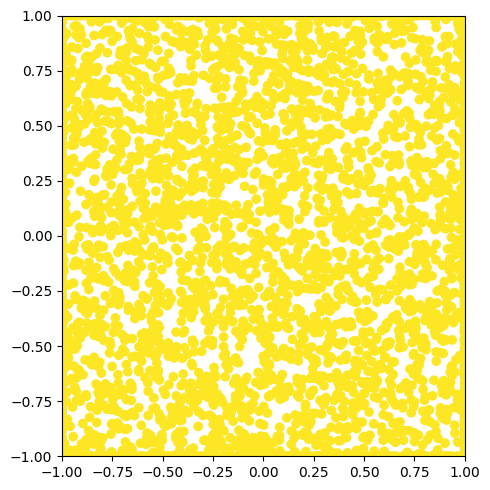

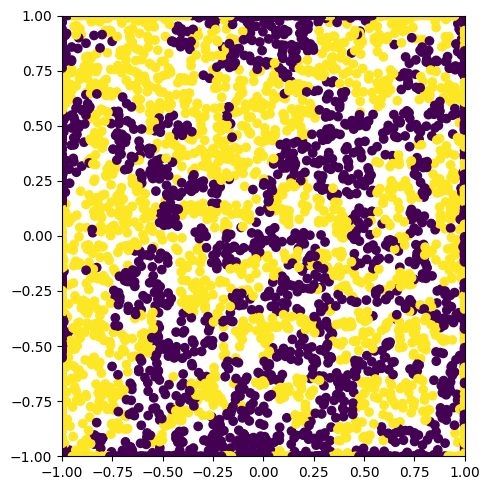

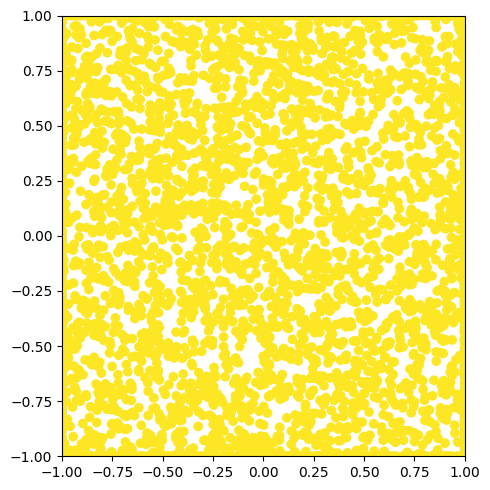

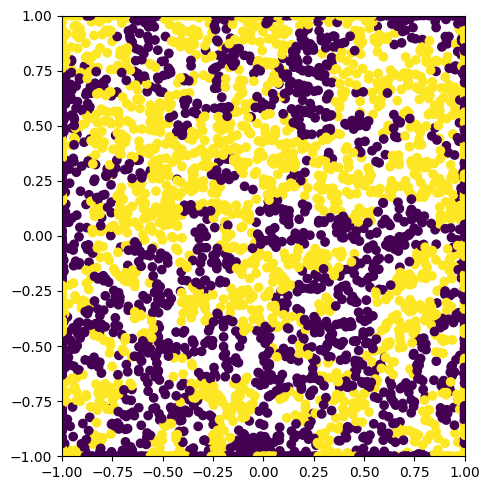

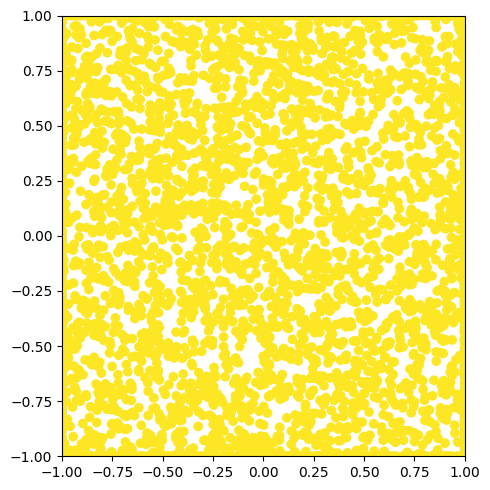

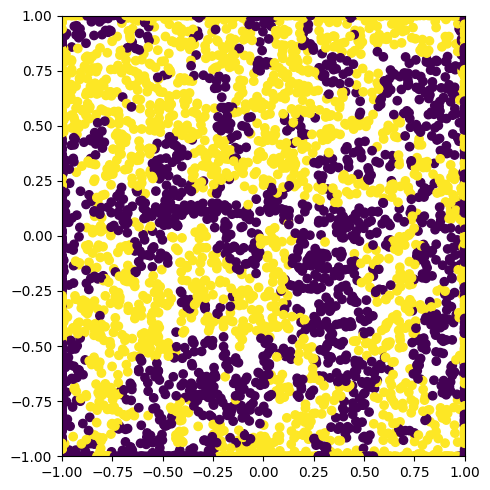

In [9]:
# We need to follow the equation: (u_-u_curr)/cfg.dt  = \nabla p/rho
# and:                             \nabla \dot u = 0 && BC

for time in range(model.num_time_feature):
    if time>=1:
        u_curr,L_u_curr,samples = model.semi_lagrangian_advection(model.total_samples.reshape(model.num_time_feature,-1,model.dim),uk,time)
        # we do not consider "g" temporally
        # ot:tqhej;L1 tqhejd
        velos, samples = u_curr,samples.reshape(-1,model.dim)

        velos = velos.detach().cpu().numpy()
        #print(velos.shape)
        samples = samples.detach().cpu().numpy()
        velos = velos.reshape(-1,model.variable_list[0])
        samples = samples.reshape(-1,2)
        #print(velos.shape,samples.shape)
        #print(np.max(velos[:,:].reshape(-1,2),axis=0))
        #fig = draw_vector_field2D(velos[:,:], samples[:,:])
        lap_use = lap[time]
        ##fix for solving poisson equation
        # print(lap.shape)
        # print(L_u_curr.shape)
        LHS_1 = -lap_use[model.inner_pts].reshape(model.inner_pts.shape[0],-1)/cfg.rho
        RHS_1 = L_u_curr[model.inner_pts].reshape(model.inner_pts.shape[0])/cfg.dt
        idx1 = idx_box[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:].squeeze(2) 
        idx1 = idx1.reshape(model.inner_pts.shape[0],-1)      
        dimk = torch.linspace(0,idx1.shape[0]-1,idx1.shape[0]).to(model.device).unsqueeze(-1).repeat(1,idx1.shape[1])
        idx1 = torch.stack([idx1,dimk],dim=2).reshape(-1,2)    


        
        part_1 = ot[time,model.inner_pts,:,:model.variable_list[0],:]/cfg.dt
        part_2 = -lap_g[time,model.inner_pts]/cfg.rho
        RHS_2 = u_curr[model.inner_pts]/cfg.dt
        part_1 = part_1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        part_2 = part_2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        LHS_2 = torch.cat([part_1,part_2],dim=1)
        RHS_2 = RHS_2.reshape(model.inner_pts.shape[0]*model.variable_list[0])
        #idx1 = model.expand_idx(idx[model.inner_pts],0,model.variable_list[0]) #(qe)hj
        idx2_part1 = idx_box[model.inner_pts,...,:model.variable_list[0],:]
        idx2_part2 = idx_box[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:]
        idx2_part2 = idx2_part2.unsqueeze(-1).expand(-1,-1,-1,-1,model.variable_list[0]).squeeze(2)
        idx2_part1 = idx2_part1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        idx2_part2 = idx2_part2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        idx2 = torch.cat([idx2_part1,idx2_part2],dim=1)
        #print(LHS_1.shape,idx1.shape)
        dimk = torch.linspace(0,idx2.shape[0]-1,idx2.shape[0]).to(model.device).unsqueeze(-1).repeat(1,idx2.shape[1])
        idx2 = torch.stack([idx2,dimk],dim=2).reshape(-1,2)      

        # part_1 = ot[time,model.inner_pts,:,:model.variable_list[0],:]/cfg.dt
        # ## Here is wrong with pressure (MAYBE!!!!!)
        # part_2 = -L1[time,model.inner_pts,:,model.variable_list[0]:model.variable_list[1],:,:]/cfg.rho
        # part_2 = part_2.squeeze(2)
        # print(part_2.shape)
        # RHS_1 = u_curr[model.inner_pts]/cfg.dt
        # part_1 = part_1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        # part_2 = part_2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        # print(part_1.shape,part_2.shape)
        # LHS_1 = torch.cat([part_1,part_2],dim=1)
        # RHS_1 = RHS_1.reshape(model.inner_pts.shape[0]*model.variable_list[0])
        # #idx1 = model.expand_idx(idx[model.inner_pts],0,model.variable_list[0]) #(qe)hj
        # idx1_part1 = idx_box[model.inner_pts,...,:model.variable_list[0],:]
        # idx1_part2 = idx_box[model.inner_pts,...,model.variable_list[0]:model.variable_list[1],:]
        # idx1_part2 = idx1_part2.unsqueeze(-1).expand(-1,-1,-1,-1,model.variable_list[0]).squeeze(2)
        # idx1_part1 = idx1_part1.permute(0,2,1,3).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        # idx1_part2 = idx1_part2.permute(0,3,1,2).reshape(model.inner_pts.shape[0]*model.variable_list[0],-1)
        # idx1 = torch.cat([idx1_part1,idx1_part2],dim=1)
        # #print(LHS_1.shape,idx1.shape)
        # dimk = torch.linspace(0,idx1.shape[0]-1,idx1.shape[0]).to(model.device).unsqueeze(-1).repeat(1,idx1.shape[1])
        # idx1 = torch.stack([idx1,dimk],dim=2).reshape(-1,2)        
        
        # num = 0
        # # LHS2: qhej
        # LHS_2 = torch.einsum('qhdjd->qhdj',L1[time,model.inner_pts,...,:model.variable_list[0],:,:])
        # RHS_2 = torch.zeros_like(ot[time,model.inner_pts,0,0,0])
        # LHS_2 = LHS_2.permute(0,2,1,3).reshape(model.inner_pts.shape[0],-1)
        # RHS_2 = RHS_2.reshape(model.inner_pts.shape[0])
        # #idx2 = model.expand_idx(idx[model.inner_pts],0,model.variable_list[0]) #(qe)hj
        # idx2 = idx_box[model.inner_pts,...,:model.variable_list[0],:]
        # idx2 = idx2.permute(0,2,1,3).reshape(model.inner_pts.shape[0],-1)

        # dimk = torch.linspace(num,num+LHS_2.shape[0]-1,LHS_2.shape[0]).to(model.device).unsqueeze(1).repeat(1,LHS_2.shape[1])
        # idx2 = torch.stack([idx2,dimk],dim=2).reshape(-1,2)




        num = 0
        # LHS3: q'hej (Some problem!!!)
        #print("norm",model.norm.shape)
        LHS_3 = torch.einsum('qhdj,qd->qhdj',ot[time,model.neu_bound,:,:model.variable_list[0]], model.norm)
        RHS_3 = torch.zeros_like(ot[time,model.neu_bound,0,0,0])
        LHS_3 = LHS_3.permute(0,2,1,3).reshape(model.neu_bound.shape[0],-1)
        RHS_3 = RHS_3.reshape(model.neu_bound.shape[0])
        #idx3 = model.expand_idx_norm(idx[model.neu_bound],0,model.variable_list[0]) #(q)ehj
        idx3 = idx_box[model.neu_bound,:,:model.variable_list[0]]
        idx3 = idx3.permute(0,2,1,3).reshape(model.neu_bound.shape[0],-1)
        dimk = torch.linspace(num,num+LHS_3.shape[0]-1,LHS_3.shape[0]).unsqueeze(-1).repeat(1,LHS_3.shape[1]).to(model.device)
        idx3 = torch.stack([idx3,dimk],dim=2).reshape(-1,2)


        # LHS4: q'hej
        num = 0
        LHS_4 = ot[time,model.dir_bound,...,model.variable_list[0]:model.variable_list[1],:]
        RHS_4 = torch.zeros_like(ot[time,model.dir_bound,0,0,0])
        LHS_4 = LHS_4.permute(0,2,1,3).reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
        RHS_4 = RHS_4.reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]))
        #idx4 = model.expand_idx(idx[model.dir_bound],model.variable_list[0],model.variable_list[1]) #(qe)hj
        idx4 = idx_box[model.dir_bound,...,model.variable_list[0]:model.variable_list[1],:]
        idx4 = idx4.permute(0,2,1,3).reshape(model.dir_bound.shape[0]*(model.variable_list[1]-model.variable_list[0]),-1)
        dimk = torch.linspace(num,num+LHS_4.shape[0]-1,LHS_4.shape[0]).unsqueeze(-1).repeat(1,LHS_4.shape[1]).to(model.device)
        idx4 = torch.stack([idx4,dimk],dim=2).reshape(-1,2)

        num = 0
        # LHS5: q'hej
        LHS_5 = ot[time,model.u_left,...,:model.variable_list[0],:]

        RHS_5 = torch.zeros_like(ot[time,model.u_left,0,:model.variable_list[0],0])
        RHS_5[...,1] = 0
        RHS_5[...,0] = model.internal_v
        LHS_5 = LHS_5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)
        #print(RHS_5)
        RHS_5 = RHS_5.reshape(model.u_left.shape[0]*model.variable_list[0])
        # idx5 = model.expand_idx(idx[model.u_left],0,model.variable_list[0]) #(qe)hj
        idx5 = idx_box[model.u_left,...,:model.variable_list[0],:]
        idx5 = idx5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)

        dimk = torch.linspace(num,num+LHS_5.shape[0]-1,LHS_5.shape[0]).unsqueeze(-1).repeat(1,LHS_5.shape[1]).to(model.device)
        idx5 = torch.stack([idx5,dimk],dim=2).reshape(-1,2)

        LHS_tp = [LHS_1,LHS_2,LHS_3,LHS_4,LHS_5]
        RHS_tp = [RHS_1,RHS_2,RHS_3,RHS_4,RHS_5]
        idx_tp = [idx1,idx2,idx3,idx4,idx5]
        linear_solver(LHS_tp,RHS_tp,idx_tp,time)
        uk,p = model.inference_time(model.total_samples.reshape(model.num_time_feature,-1,model.dim),time)
        
    else:
        # NEED Something in LHS5
        num = 0
        # LHS5: q'hej
        LHS_5 = ot[time,model.u_left,...,:model.variable_list[0],:]
        #print(model.u_left)
        RHS_5 = torch.zeros_like(ot[time,model.u_left,0,:model.variable_list[0],0])
        RHS_5[...,1] = 0
        RHS_5[...,0] = model.internal_v
        LHS_5 = LHS_5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)
        #print(RHS_5)
        RHS_5 = RHS_5.reshape(model.u_left.shape[0]*model.variable_list[0])
        # idx5 = model.expand_idx(idx[model.u_left],0,model.variable_list[0]) #(qe)hj
        idx5 = idx_box[model.u_left,...,:model.variable_list[0],:]
        idx5 = idx5.permute(0,2,1,3).reshape(model.u_left.shape[0]*model.variable_list[0],-1)

        dimk = torch.linspace(num,num+LHS_5.shape[0]-1,LHS_5.shape[0]).unsqueeze(-1).repeat(1,LHS_5.shape[1]).to(model.device)
        idx5 = torch.stack([idx5,dimk],dim=2).reshape(-1,2)
           
        num = 0
        # LHS6: q'hej
        LHS_6 = ot[time,model.init_pts]
        RHS_6 = torch.zeros_like(ot[time,model.init_pts,0,:,0])
        LHS_6 = LHS_6.permute(0,2,1,3).reshape(model.init_pts.shape[0]*model.variable_list[1],-1)
        RHS_6 = RHS_6.reshape(model.init_pts.shape[0]*model.variable_list[1])
        # idx6 = model.expand_idx(idx[model.init_pts],0,model.variable_list[1]) #(qe)hj
        idx6 = idx_box[model.init_pts]
        idx6 = idx6.permute(0,2,1,3).reshape(model.init_pts.shape[0]*model.variable_list[1],-1)
        dimk = torch.linspace(num,num+LHS_6.shape[0]-1,LHS_6.shape[0]).unsqueeze(-1).repeat(1,LHS_6.shape[1]).to(model.device)
        idx6 = torch.stack([idx6,dimk],dim=2).reshape(-1,2)
        #print(model.init_pts,model.u_left)
        LHS_tp = [LHS_5,LHS_6]
        RHS_tp = [RHS_5,RHS_6]
        idx_tp = [idx5,idx6]
        linear_solver(LHS_tp,RHS_tp,idx_tp,time)
        uk,p = model.inference_time(model.total_samples.reshape(model.num_time_feature,-1,model.dim),time)


# Linear PDE solver

In [10]:

# LHS_tp = [LHS_1,LHS_2,LHS_3,LHS_4,LHS_5,LHS_6]
# RHS_tp = [RHS_1,RHS_2,RHS_3,RHS_4,RHS_5,RHS_6]
# idx_tp = [idx1,idx2,idx3,idx4,idx5,idx6]



def linear_solver(LHS_tp,RHS_tp,idx_tp):
    LHS = []
    RHS = []
    idx = []
    num = 0
    for i,LHS_ in enumerate(LHS_tp):
        max_x = torch.abs(LHS_).max()
        if max_x>0.0:
            LHS.append(LHS_/max_x)
            RHS.append(RHS_tp[i]/max_x)
            idx_tp[i][:,1] = idx_tp[i][:,1] + num
            idx.append(idx_tp[i])
            print(LHS_.shape[0]*LHS_.shape[1],idx_tp[i].shape[0])
            num += LHS_.shape[0] 
    #LHS: q?h?ej
    q = sum([i.shape[0] for i in LHS])
    h = model.num_time_feature*model.num_spatial_basis*model.variable_num*model.num_per_point_feature

    LHS = torch.cat([i.reshape(-1) for i in LHS],dim=0)
    idx = torch.cat(idx,dim=0).long()
    # mask = (LHS==0)
    # LHS = LHS[~mask]
    # idx = idx[~mask]

    #print(LHS.shape,idx.shape)
    # print(h)
    idx = torch.stack([idx[:,1],idx[:,0]],dim=1)

    # cuda cupy ver
    #A = torch.sparse_coo_tensor(idx.transpose(0,1),LHS,[q,h])
    #b = torch.cat(RHS,dim=0)
    LHS_s = LHS
    idx_s = idx
    # numpy ver
    LHS = LHS.double().detach().cpu().numpy()
    idx = idx.detach().cpu().numpy()
    A = sparse.coo_matrix((LHS,(idx[:,0],idx[:,1])),shape=(q,h)).tocsr()
    b = torch.cat(RHS,dim=0).unsqueeze(1).double().detach().cpu().numpy()
    # print(b.shape)


    utz = A.shape[1]
    idxu = (A.getnnz(0)>0)
    A = A[:,A.getnnz(0)>0]
    out = sparse.linalg.lsqr(A,b)
    b_ = b
    #print(out[1:5])

    a,b,c,d = model.u_.shape
    u = out[0]
    # print(np.sum(np.abs(u)))
    ut = np.zeros(utz)
    ut[idxu] = u
    ut = torch.from_numpy(ut).to(model.device)

    model.u_ = model.u_.reshape(-1)
    model.u_ = ut
    model.u_ = model.u_.reshape(a,b,c,d)

    # A_ = torch.sparse_coo_tensor(idx_s.transpose(0,1),LHS_s,(q,h))
    # print(A_@model.u_.reshape(-1).float())

    # print(model.u_)

    # velos, samples = model.sample_field(model.vis_resolution,model.vis_resolution//20, return_samples=True)

    grid_samples = sample_uniform(model.vis_resolution, 2, device=model.device, flatten=True).requires_grad_(True)
    boundary_samples,norm = model.process_boundary(model.vis_resolution//20)
    total_samples = torch.cat([grid_samples,boundary_samples],dim=0)
    total_samples,t,norm = model.process_time(model.time_num,model.time_length,total_samples,norm)

    # fig, ax = plt.subplots(figsize=(5, 5))
    # ax.scatter(total_samples[:,0].detach().cpu().numpy(), total_samples[:,1].detach().cpu().numpy())

    # print(total_samples)
    #print(model.basis_point.shape)
    out,p = model.inference(model.total_samples[model.u_left].reshape(-1,2),model.t[model.u_left].reshape(-1,1))
    velos, samples = out,model.total_samples[model.u_left]
    velos = velos.detach().cpu().numpy()
    #print(velos)
    samples = samples.detach().cpu().numpy()
    velos = velos.reshape(model.time_num,-1,model.variable_list[1])
    samples = samples.reshape(model.time_num,-1,2)
    #print(velos.shape,samples.shape)
    print(np.max(velos[0,:,:model.variable_list[0]].reshape(-1,2),axis=0))
    fig = draw_vector_field2D(velos[0,:,:model.variable_list[0]], samples[0,:,:])
